# Imports

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split

import mne
from mne import Epochs, pick_types, events_from_annotations, set_log_level
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from tqdm.notebook import tqdm

set_log_level("WARNING")
N_PARALLEL=6

# Get Data (1 subject)

In [199]:
REAL = "real"
IMAGINED = "imagined"

LR = 'L vs R'
HAND_FEET = 'Hands vs feet'

tasks = [
    {
        "name": "Real moving hands",
        "real": True,
        "type": LR,
        "runs": [3, 7, 11],
        "labels": {0: "rest", 1: "left hand", 2: "right hand"},
    },
    {
        "name": "Imagine moving hands",
        "real": False,
        "type": LR,
        "runs": [4, 8, 12],
        "labels": {0: "rest", 1: "imagine left hand", 2: "imagine right hand"},
    },
    {
        "name": "move hands vs feet",
        "real": True,
        "type": HAND_FEET,
        "runs": [5, 9, 13],
        "labels": {0: "rest", 1: "hands", 2: "feet"},
    },
    {
        "name": "imagine hands vs feet",
        "real": False,
        "type": HAND_FEET,
        "runs": [6, 10, 14],
        "labels": {0: "rest", 1: "imagine both hands", 2: "imagine both feet"},
    }
]

task_number = 0
subject = 1

tmin, tmax = -1., 4.
noisy_channels = ['AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'Fp1', 'Fpz', 'Fp2', 'P7', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6',
                    'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'Iz']

def get_epochs(task_number: int, subject_number: int, baseline: float = None, tmin: float = -1., tmax: float = 4.0, montage_name: str = 'standard_1005', noisy_channels: List[str] = noisy_channels) -> Epochs:
    runs = tasks[task_number]['runs']
    labels = tasks[task_number]["labels"]

    # print(f"Getting epochs for {tasks[task_number]['name']} {subject_number = }.")

    raw_fnames = eegbci.load_data(subject_number, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    eegbci.standardize(raw)  # set channel names
    montage = make_standard_montage(montage_name)
    raw.set_montage(montage)

    events, _ = mne.events_from_annotations(raw, event_id=dict(T1=1, T2=2))
    annotations = mne.annotations_from_events(events=events, event_desc=labels, sfreq=raw.info["sfreq"])

    raw.drop_channels(noisy_channels)
    raw.notch_filter(60, method="iir")
    raw.filter(7.0, 32.0, fir_design="firwin", skip_by_annotation="edge")

    events, event_ids = mne.events_from_annotations(raw)
    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,exclude=noisy_channels)
    if baseline:
        epochs = Epochs(raw, events, event_ids, tmin, tmax, proj=True, picks=picks, baseline=(tmin, tmin + 1.), preload=True)
    else:
        epochs = Epochs(raw, events, event_ids, tmin, tmax, proj=True, picks=picks, preload=True)

    return epochs

In [113]:
def cross_val_pipeline(pipeline, epochs) -> float:
    targets = epochs.events[:, -1]
    epochs_data = epochs.copy().crop(tmin=1.0, tmax=4.0).get_data() # They do this cropping on MNE website. Why ?

    scores = cross_val_score(pipeline, epochs_data, targets, cv=ShuffleSplit(10, test_size=0.2), n_jobs=None)
    print(f"Cross validation average {scores.mean():.2f}")
    return scores.mean()


def train_pipeline(pipeline: Pipeline, epochs, test_size = 0.1) -> Pipeline:
    targets = epochs.events[:, -1]
    epochs_data = epochs.copy().crop(tmin=1.0, tmax=4.0).get_data() # They do this cropping on MNE website. Why ?

    x_train, x_test, y_train, y_test = train_test_split(epochs_data, targets, test_size=test_size, random_state=0)

    x_train, y_train = epochs_data, targets
    pipeline.fit(X=x_train, y=y_train)
    score = pipeline.score(X=x_test, y=y_test)
    print(f"trained_pipeline_score: {score:.2f}")

    return pipeline


# print()
e = get_epochs(task_number=0, subject_number=16)

csp = CSP(n_components=4)
lda_shrimp = LDA(solver='lsqr', shrinkage='auto')
pipeline = Pipeline([("CSP", csp), ("LDA", lda_shrimp)])

score = cross_val_pipeline(pipeline, e)
trained_pipeline = train_pipeline(pipeline, e)
print(score)


Cross validation average 0.73
trained_pipeline_score: 0.67
0.7333333333333334


In [208]:
number_of_subjects = 20
lda_types = ['classic', 'shrimp']
csp_components = [4, 6]
# lda_types = ['shrimp']
results = {}

def build_pipe(lda_name: str = 'classic', csp_components: int = 4) -> Pipeline:
    if (lda_name == 'shrimp'):
        lda = LDA(solver='lsqr', shrinkage='auto')
    elif lda_name == 'classic':
        lda = LDA()
    csp = CSP(n_components=csp_components)
    pipeline = Pipeline([("CSP", csp), ("LDA", lda)])
    return pipeline

import pandas as pd

training_data = pd.DataFrame(columns=['subject', 'task_number', 'cross_val_score', 'lda_name', 'baseline_corrected', 'csp_n_components'])


for lda_name in tqdm(lda_types, desc='lda_name'):
    for csp_n_components in tqdm(csp_components, desc='csp_n_components'):
        for baseline_correct in tqdm([1.0, None], desc='baseline_correct'):
            for task_number in tqdm(range(4), desc='task_number'):
                for subject in tqdm(range(1, number_of_subjects + 1), desc='subject'):
                    epochs = get_epochs(task_number, subject, baseline=baseline_correct)
                    pipe = build_pipe(lda_name=lda_name, csp_components=csp_n_components)
                    # pipe = train_pipeline(pipe, epochs, test_size=0.01)
                    cross_score = cross_val_pipeline(pipe, epochs)
                    training_data = training_data.append({
                        'subject': subject,
                        'task_number': task_number,
                        'cross_val_score': cross_score,
                        'lda_name': lda_name,
                        'baseline_corrected': baseline_correct,
                        'csp_n_components': csp_n_components
                    }, ignore_index = True)
training_data.to_csv("TRAINING.csv")

lda_name:   0%|          | 0/2 [00:00<?, ?it/s]

csp_n_components:   0%|          | 0/2 [00:00<?, ?it/s]

baseline_correct:   0%|          | 0/2 [00:00<?, ?it/s]

task_number:   0%|          | 0/4 [00:00<?, ?it/s]

subject:   0%|          | 0/20 [00:00<?, ?it/s]

Cross validation average 0.75
  subject task_number  cross_val_score lda_name  baseline_corrected  \
0       1           0             0.75  classic                 1.0   

  csp_n_components  
0                4  


/tmp/ipykernel_9635/2113683345.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  training_data = training_data.append({


Cross validation average 0.59
  subject task_number  cross_val_score lda_name  baseline_corrected  \
0       1           0         0.750000  classic                 1.0   
1       2           0         0.588889  classic                 1.0   

  csp_n_components  
0                4  
1                4  


/tmp/ipykernel_9635/2113683345.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  training_data = training_data.append({


In [203]:
training_data

,subject,task,cross_val_score,model,baseline_corrected


In [169]:
import time

e = get_epochs(task_number=0, subject_number=16)
pipeline = build_pipe('shrimp')
trained_pipeline = train_pipeline(pipeline, e)

# trained_pipeline.predict(e.get_data())
print("score", trained_pipeline.score(e.get_data(), e.events[:, -1]))
epochs_data = e.get_data()
events = e.events
last_time = 0
threshold = 0.8
right = 0
wrong = 0
for i, event in enumerate(events):
    # print(event[0] - last_time, "ms")
    last_time = event[0]
    prediction_distribution = trained_pipeline.predict_proba(epochs_data[i, None, :, :])
    # print(epochs_data[i, None, :, :].shape)
    if np.max(prediction_distribution) > threshold:
        prediction = np.argmax(prediction_distribution) + 1
        right += prediction == event[2]
        wrong += prediction != event[2]

print(f"{right = }\n{wrong = }\n{right/(right + wrong) = }")


trained_pipeline_score: 0.67
score 0.6781609195402298
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 801)
(1, 42, 80

In [161]:
num_epochs = epochs_data.shape[0]
measurements_per_epoch = epochs_data.shape[2]
stack = np.zeros((num_epochs * measurements_per_epoch, epochs_data.shape[1]), dtype=np.float64)
events_stak = np.zeros(num_epochs * measurements_per_epoch,)
epochs_data.shape
for e in range(num_epochs):
    for t in range(measurements_per_epoch):
        stack[e * measurements_per_epoch + t] = epochs_data[e, :, t]
        events_stak[e * measurements_per_epoch + t] = events[e][-1]
        # print(epochs_data[e, :, t].shape)


(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)


In [193]:
right = 0
wrong = 0
threshold = 0.80
predictions_made = np.zeros(((num_epochs - 1) * measurements_per_epoch))
predictions_made_e = np.zeros((num_epochs))

for t in tqdm(range((num_epochs - 1) * measurements_per_epoch)):
    t_min = t
    t_max = t + measurements_per_epoch
    data = stack[None, t_min:t_max, :]
    data = np.swapaxes(data, 1, 2)
    gt = events_stak[t]
    # print(data.shape)
    # break
    prediction_distribution = trained_pipeline.predict_proba(data)
    prediction = None
    if np.max(prediction_distribution) > threshold or True:
        prediction = np.argmax(prediction_distribution) + 1
        right += prediction == gt
        wrong += prediction != gt
        predictions_made[t] = True
        e = t // measurements_per_epoch
        predictions_made_e[e] = 1.
        print(prediction, gt)
    # time.sleep(65. / 1000)

print(f"{right = }\n{wrong = }\n{right/(right + wrong) = }\n{predictions_made_e.mean() = }")

  0%|          | 0/68886 [00:00<?, ?it/s]

3 3.0
3 3.0
3 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.0
2 3.

KeyboardInterrupt: 

In [185]:
import matplotlib
import matplotlib.pyplot as plt

# plt.plot(predictions_made)
# plt.plot(predictions_made_e)

0.41379310344827586

# Define Pipeline & Cross validation

In [59]:

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
# scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=None)
scores = cross_val_score(clf, epochs_data_stak, labels_stak, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))


Classification accuracy: 0.544856 / Chance level: 0.511111


# Training

In [60]:
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
clf = Pipeline([('CSP', csp), ('LDA', lda)])
epochs_data = epochs.get_data()
epochs_data.shape

(45, 64, 801)

In [61]:
from tqdm import tqdm

sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

cv_split = cv.split(epochs_data_stak)
train_indexes, test_indexes = next(cv_split)

scores = []
for i in tqdm(range(10)):
    # y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_stak[train_indexes], labels_stak[train_indexes])
    X_test = csp.transform(epochs_data_stak[test_indexes])

    # fit classifier
    lda.fit(X_train, labels_stak[train_indexes])
    scores.append(lda.score(X_test, labels_stak[test_indexes]))
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data_stak[test_indexes][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, labels_stak[test_indexes]))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
# plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.plot(scores, label='Scores')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

 50%|█████     | 5/10 [00:31<00:31,  6.23s/it]

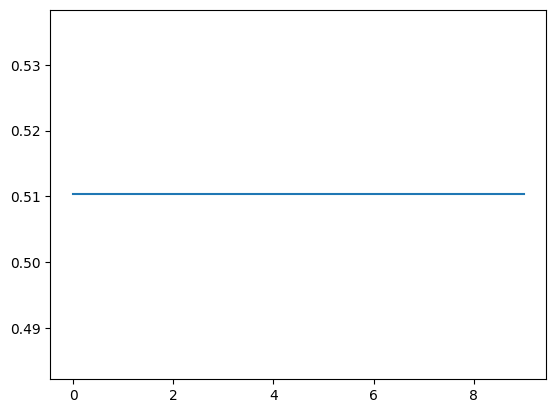

In [ ]:
plt.plot(scores, label='Scores')
